In [1]:
import physicsnemo.sym
from physicsnemo.sym.hydra import instantiate_arch, PhysicsNeMoConfig
from physicsnemo.sym.key import Key

from physicsnemo.sym.solver import Solver
from physicsnemo.sym.domain import Domain
from physicsnemo.sym.domain.constraint import SupervisedGridConstraint
from physicsnemo.sym.domain.validator import GridValidator
from physicsnemo.sym.dataset import DictGridDataset
from physicsnemo.sym.utils.io.plotter import GridValidatorPlotter

from utilities import download_FNO_dataset, load_FNO_dataset

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:91: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _EPOCH_DATETIME_NAIVE = datetime.datetime.utcfromtimestamp(0)


In [2]:
import matplotlib.pyplot as plt

In [3]:
input_keys = [Key("coeff", scale=(7.48360e00, 4.49996e00))]
output_keys = [Key("sol", scale=(5.74634e-03, 3.88433e-03))]

The scales above must have been computed from the original dataset. In the `load_FNO_dataset()` function, they just calculate the mean and std of the dataset and print it. It looks like the `darcy_FNO` just creates the input and output keys with the scales ahead of time. Weird chicken-before-the-egg setup...

In [4]:
invar_train, outvar_train = load_FNO_dataset(
    "datasets/Darcy_241/piececonst_r241_N1024_smooth1.hdf5",
    [k.name for k in input_keys],
    [k.name for k in output_keys],
    n_examples=1000,
)

loaded: /sci-ml/pino-darcy/datasets/Darcy_241/piececonst_r241_N1024_smooth1.hdf5
avaliable keys: ['Kcoeff', 'Kcoeff_x', 'Kcoeff_y', 'coeff', 'sol']
selected key: coeff, mean: 7.48360e+00, std: 4.49996e+00
selected key: sol, mean: 5.74634e-03, std: 3.88433e-03


In [6]:
print(invar_train.keys())
print(outvar_train.keys())

dict_keys(['coeff'])
dict_keys(['sol'])


In [ ]:
invar_train["coeff"].shape

(1000, 1, 241, 241)

In [26]:
print(invar_train["coeff"].mean())
print(invar_train["coeff"].std())

7.483603
4.4999623


In [23]:
k = invar_train["coeff"][0][0]
k.shape

(241, 241)

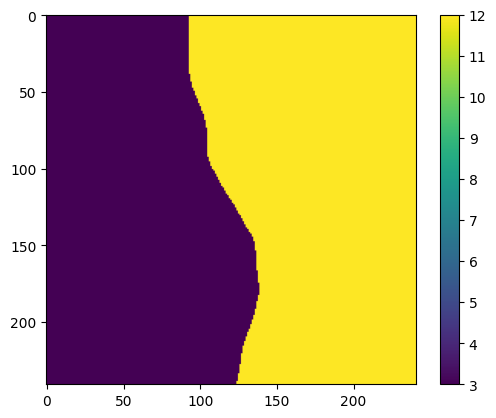

In [24]:
im = plt.imshow(k, cmap='viridis')
cbar = plt.colorbar(im)
plt.show()

In [19]:
outvar_train["sol"].shape

(1000, 1, 241, 241)

In [20]:
u = outvar_train["sol"][0][0]
u.shape

(241, 241)

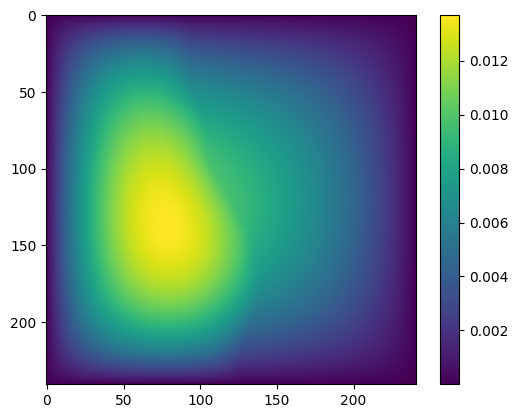

In [22]:
im = plt.imshow(u, cmap='viridis')
cbar = plt.colorbar(im)
plt.show()

Load original data file and see what's inside

In [7]:
import h5py

In [8]:
data = data = h5py.File("datasets/Darcy_241/piececonst_r241_N1024_smooth2.hdf5", "r")

In [9]:
data.keys()

<KeysViewHDF5 ['Kcoeff', 'Kcoeff_x', 'Kcoeff_y', 'coeff', 'sol']>

In [10]:
data["coeff"].shape

(1024, 1, 241, 241)

The original data file is just a dictionary containing key-value pairs. The purpose of `load_FNO_dataset()` is to separate the input data from the output data and to limit the number of samples used for training.

`invar` and `outvar` grid datasets are already inside dictionaries. We wrap them inside a `DictGridDataset` for easier handling of the grid data by solver later.

In [11]:
invar_test, outvar_test = load_FNO_dataset(
    "datasets/Darcy_241/piececonst_r241_N1024_smooth2.hdf5",
    [k.name for k in input_keys],
    [k.name for k in output_keys],
    n_examples=100,
)

loaded: /sci-ml/pino-darcy/datasets/Darcy_241/piececonst_r241_N1024_smooth2.hdf5
avaliable keys: ['Kcoeff', 'Kcoeff_x', 'Kcoeff_y', 'coeff', 'sol']
selected key: coeff, mean: 7.60960e+00, std: 4.49867e+00
selected key: sol, mean: 5.62588e-03, std: 3.80937e-03


In [12]:
train_dataset = DictGridDataset(invar_train, outvar_train)
test_dataset = DictGridDataset(invar_test, outvar_test)

In [13]:
print(train_dataset.invar["coeff"].shape)
print(train_dataset.length)

torch.Size([1000, 1, 241, 241])
1000


---

Darcy PINO

In [36]:
input_keys = [
    Key("coeff", scale=(7.48360e00, 4.49996e00)),
    Key("Kcoeff_x"),
    Key("Kcoeff_y"),
]
output_keys = [
    Key("sol", scale=(5.74634e-03, 3.88433e-03)),
]

invar_train, outvar_train = load_FNO_dataset(
    "datasets/Darcy_241/piececonst_r241_N1024_smooth1.hdf5",
    [k.name for k in input_keys],
    [k.name for k in output_keys],
    n_examples=1000,
)
invar_test, outvar_test = load_FNO_dataset(
    "datasets/Darcy_241/piececonst_r241_N1024_smooth2.hdf5",
    [k.name for k in input_keys],
    [k.name for k in output_keys],
    n_examples=100,
)

loaded: /sci-ml/pino-darcy/datasets/Darcy_241/piececonst_r241_N1024_smooth1.hdf5
avaliable keys: ['Kcoeff', 'Kcoeff_x', 'Kcoeff_y', 'coeff', 'sol']
selected key: coeff, mean: 7.48360e+00, std: 4.49996e+00
selected key: Kcoeff_x, mean: 3.96410e-02, std: 2.42777e+01
selected key: Kcoeff_y, mean: -1.38027e-01, std: 2.44358e+01
selected key: sol, mean: 5.74634e-03, std: 3.88433e-03
loaded: /sci-ml/pino-darcy/datasets/Darcy_241/piececonst_r241_N1024_smooth2.hdf5
avaliable keys: ['Kcoeff', 'Kcoeff_x', 'Kcoeff_y', 'coeff', 'sol']
selected key: coeff, mean: 7.60960e+00, std: 4.49867e+00
selected key: Kcoeff_x, mean: -1.90794e-01, std: 2.48023e+01
selected key: Kcoeff_y, mean: 3.77750e-01, std: 2.44787e+01
selected key: sol, mean: 5.62588e-03, std: 3.80937e-03


In [38]:
print(invar_train["Kcoeff_x"].shape)
print(invar_train["Kcoeff_y"].shape)


(1000, 1, 241, 241)
(1000, 1, 241, 241)


In [42]:
idk_x = invar_train["Kcoeff_x"][0][0]

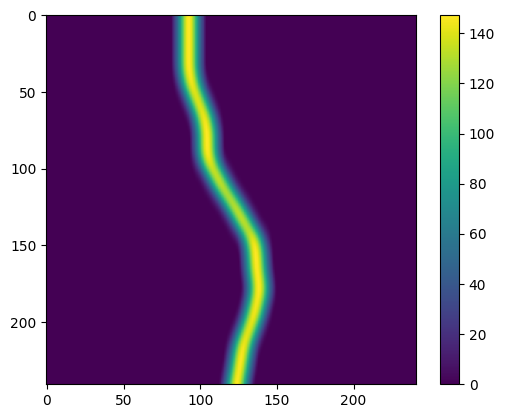

In [43]:
im = plt.imshow(idk_x, cmap='viridis')
cbar = plt.colorbar(im)
plt.show()

In [44]:
idk_y = invar_train["Kcoeff_y"][0][0]

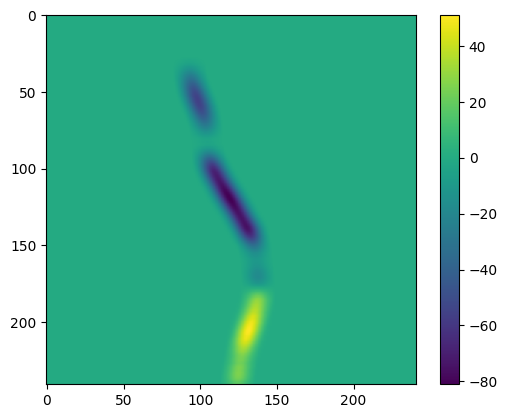

In [45]:
im = plt.imshow(idk_y, cmap='viridis')
cbar = plt.colorbar(im)
plt.show()